In [2]:
import json

import numpy as np
import torch

from nl.autoencoders import AutoencoderConfig, AutoencoderLatents

from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import glob
        

# Helper functions

In [7]:
def per_feature_scores(feature_results):
        """
        This function gets a dictionary of feature results. The key is the feature number and the value is a dictionary with the following keys:
        - "prediction": the prediction of the model
        - "ground_truth": if the feature is active or not
        - "probability": the probability of the prediction
        - "order": the order of the feature if it is active
        - "text": the text of the sentence


        It should return a dictionary with on average how many times each feature is active and the model is able to predict it correctly and how many times it is not active and the model is able to predict it correctly.
        """
        scores = []

        # Max position
        max_position = feature_results["order"].max()

        for index, row in feature_results.iterrows():

            # Initialize scores for this feature if not already present
            score = {
                    "feature": row["feature"],
                    "true_positives": 0,
                    "true_negatives": 0,
                    "total_inactive": 0,
                    "total_active": 0,
                    "active_accuracy": 0,
                    "inactive_accuracy": 0,
                    "position": -1,
                }
            
            # Count active vs inactive
            if row["ground_truth"]:
                score["position"] = (max_position-row["order"])/max_position
                score["total_active"] += 1
                if row["prediction"]:
                    score["true_positives"] += 1
                else:
                    score["active_accuracy"] = 0
            else:
                score["total_inactive"] += 1
                if not row["prediction"]:
                    score["true_negatives"] += 1
            scores.append(score)
                    

        return scores


        

In [8]:
def on_average_correct(feature_results):
    """
    This function gets a dictionary of feature results. The key is the feature number and the value is a dictionary with the following keys:
    - "prediction": the prediction of the model
    - "ground_truth": if the feature is active or not
    - "probability": the probability of the prediction
    - "order": the order of the feature if it is active
    - "text": the text of the sentence

    It should compute average statistics, like the recall, precision, f1, balanced accuracy and auc.
    """
    
    # See how many are correct in general
    total_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    labels = []
    probabilities = []
    for index, row in feature_results.iterrows():
        if row["prediction"] == row["ground_truth"]:
            total_correct += 1
            if row["ground_truth"]:
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if row["ground_truth"]:
                false_negatives += 1
            else:
                false_positives += 1
        labels.append(row["ground_truth"])
        probabilities.append(row["probability"])
    if len(labels) == 0 or len(probabilities) == 0:
        return {"recall":0,"precision":0,"f1":0,"balanced_accuracy":0,"accuracy":0,"auc":0}
    
    
    if true_positives+false_negatives > 0:
        recall = true_positives/(true_positives+false_negatives)
    else:
        recall = 0
    if true_positives+false_positives > 0:
        precision = true_positives/(true_positives+false_positives)
    else:
        precision = 0
    if precision+recall > 0:
        f1 = 2*precision*recall/(precision+recall)
    else:
        f1 = 0
    if true_negatives+false_positives>0:
        balanced_accuracy = (recall+true_negatives/(true_negatives+false_positives))/2
    else:
        balanced_accuracy = 0
    if true_positives+true_negatives+false_positives+false_negatives > 0:
        accuracy = (true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives)
    else:
        accuracy = 0
    auc = roc_auc_score(labels, probabilities)

    #count how many features are active
    num_active_features = feature_results[feature_results["ground_truth"] == True].shape[0]
    #sort the feature results by probability
    sorted_feature_results = feature_results.sort_values(by="probability", ascending=False)
    #get the top num_active_features
    top_active_features = sorted_feature_results.head(49)
    #count how many of the top active features are active
    num_top_active_features = top_active_features[top_active_features["ground_truth"] == True].shape[0]
    precision_top = num_top_active_features/49


    return {"recall":recall,"precision":precision,"f1":f1,"balanced_accuracy":balanced_accuracy,"accuracy":accuracy,"auc":auc,"precision_top":precision_top}
    
    

In [9]:
def alignment_scores(feature_results):
    # get the active features
    active_features = feature_results[feature_results["ground_truth"] == True]["feature"].tolist()
    # get the idx column from the results
    
    # sort the feature results by probability
    sorted_feature_results = feature_results.sort_values(by="probability", ascending=False)
    
    # get the top number of active features
    top_active_features = sorted_feature_results.head(len(active_features))["feature"].tolist()
    
    
    decoder_directions_active = []
    decoder_directions_top = []
    decoder_directions_random = []
    random_features = np.random.choice(np.arange(131072), size=len(active_features), replace=False)
    for feature in active_features:
        decoder_directions_active.append(autoencoder.ae.W_dec.data[int(feature),:])
    for feature in top_active_features:
        decoder_directions_top.append(autoencoder.ae.W_dec.data[int(feature),:])
    for feature in random_features:
        decoder_directions_random.append(autoencoder.ae.W_dec.data[feature,:])
    decoder_directions_active = torch.stack(decoder_directions_active)
    decoder_directions_top = torch.stack(decoder_directions_top)
    decoder_directions_random = torch.stack(decoder_directions_random)
    
    reward_active = decoder_directions_active @ decoder_directions_top.T
    row_ind, col_ind = linear_sum_assignment(reward_active.cpu().numpy(), maximize=True)
    reward_active = reward_active[row_ind, col_ind].mean()
    #print(f"Reward top: {reward_active}")

    reward_random = decoder_directions_random @ decoder_directions_active.T
    row_ind, col_ind = linear_sum_assignment(reward_random.cpu().numpy(), maximize=True)
    reward_random = reward_random[row_ind, col_ind].mean()
    data = {"reward_active":reward_active.item(),"reward_random":reward_random.item()}
    return data


In [10]:
def get_scores(SCORES_FOLDER,num_sentences=5000,type="on_average"):
    results = []
    for sentence_idx in tqdm(range(num_sentences)):
        files = glob.glob(f"{SCORES_FOLDER}{sentence_idx}/*")
        feature_results = []
        for file in files:
            # read the csv
            df = pd.read_csv(file)
            feature_results.append(df)
        if len(feature_results) < 1:
            continue
        feature_results = pd.concat(feature_results)
        
        
        if type == "on_average":
            data = on_average_correct(feature_results)
            results.append(data)
        elif type == "per_feature":
            data = per_feature_scores(feature_results)
            results.extend(data)
        elif type == "alignment":
            data = alignment_scores(feature_results)
            results.append(data)
        
    if type == "on_average":
        results = pd.DataFrame(results,columns=["recall","precision","f1","balanced_accuracy","accuracy","auc","precision_top"])
    elif type == "per_feature":
        results = pd.DataFrame(results,columns=["feature","active_accuracy","inactive_accuracy","true_positives","true_negatives","total_inactive","total_active","position","active_correct"])
    if type == "alignment":
        results = pd.DataFrame(results,columns=["reward_active","reward_random"])
    return results



In [11]:
l0_dict = {11:49}

model_size = "8b"
window_size = 32

layer = 11


with open(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/explanations_131k/model.layers.{layer}_feature.json", "r") as f:
    #load json file
    all_explanations = json.load(f)

with open(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/formated_scores/gemma/131k/res/fuzz_layer_{layer}.json", "r") as f:
    #load json file
    fuzz_scores = json.load(f)

with open(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/formated_scores/gemma/131k/res/recall_layer_{layer}.json", "r") as f:
    #load json file
    recall_scores = json.load(f)

In [12]:

def dummy_forward_function(x):
    return x
config = AutoencoderConfig(
    model_name_or_path="google/gemma-scope-9b-pt-res",
    autoencoder_type="CUSTOM",
    device="cuda",
    hookpoints=[f"layer_{layer}/width_131k/average_l0_{l0_dict[layer]}"],
    kwargs={"custom_name": "gemmascope"}
)


autoencoder = AutoencoderLatents.from_pretrained(config,hookpoint=f"layer_{layer}/width_131k/average_l0_{l0_dict[layer]}")


In [15]:
average_results_top = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/131k/8b/32/top/",type="alignment")
average_results_quantiles = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/131k/8b/32/quantiles/",type="alignment")


100%|██████████| 5000/5000 [00:14<00:00, 346.98it/s] 


# Alignment

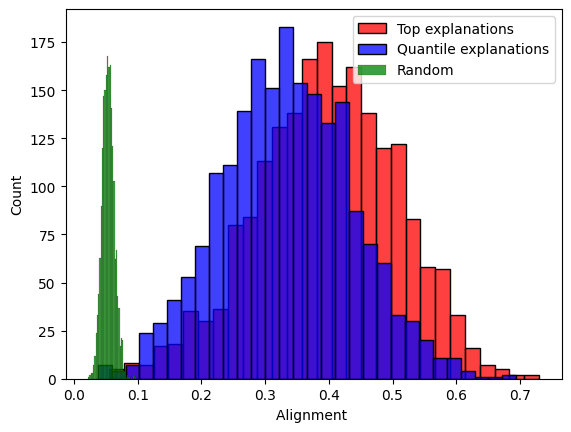

In [16]:
sns.histplot(average_results_top, x="reward_active",label="Top explanations",color="red")
sns.histplot(average_results_quantiles, x="reward_active",label="Quantile explanations",color="blue")
sns.histplot(average_results_top, x="reward_random",label="Random",color="green")
plt.xlabel("Alignment ")
#plt.xlim(0,1)
plt.legend()
plt.savefig("blog_figures/alignment_scores.svg")




# Accuracy


In [ ]:
average_results_top = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8b/32/top/",type="on_average")
average_results_quantiles = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8b/32/quantiles/",type="on_average")
average_results_fuzz = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8bfuzz/32/quantiles/",type="on_average")
average_results_recall = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8bfuzz/32/quantiles/",type="on_average")
average_results_70b = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/70b/32/quantiles/",type="on_average")


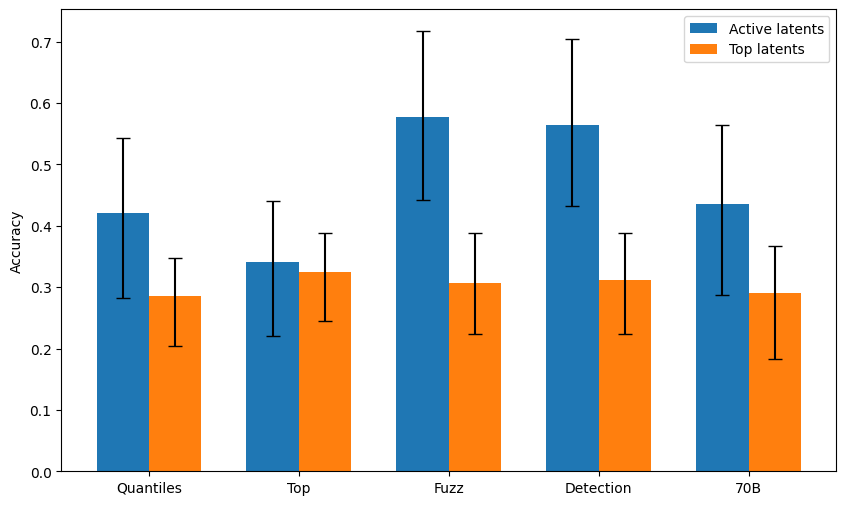

In [90]:
# Calculate mean scores and percentiles for each method
methods = ['Quantiles', 'Top', 'Fuzz', 'Detection', '70B']

# Calculate means
recall_means = [
    np.mean(average_results_quantiles["recall"]),
    np.mean(average_results_top["recall"]), 
    np.mean(average_results_fuzz["recall"]),
    np.mean(average_results_recall["recall"]),
    np.mean(average_results_70b["recall"])
]

precision_means = [
    np.mean(average_results_quantiles["precision_top"]),
    np.mean(average_results_top["precision_top"]),
    np.mean(average_results_fuzz["precision_top"]), 
    np.mean(average_results_recall["precision_top"]),
    np.mean(average_results_70b["precision_top"])
]

# Calculate 25th and 75th percentiles
recall_25 = [
    np.percentile(average_results_quantiles["recall"], 25),
    np.percentile(average_results_top["recall"], 25),
    np.percentile(average_results_fuzz["recall"], 25),
    np.percentile(average_results_recall["recall"], 25),
    np.percentile(average_results_70b["recall"], 25)
]

recall_75 = [
    np.percentile(average_results_quantiles["recall"], 75),
    np.percentile(average_results_top["recall"], 75),
    np.percentile(average_results_fuzz["recall"], 75),
    np.percentile(average_results_recall["recall"], 75),
    np.percentile(average_results_70b["recall"], 75)
]

precision_25 = [
    np.percentile(average_results_quantiles["precision_top"], 25),
    np.percentile(average_results_top["precision_top"], 25),
    np.percentile(average_results_fuzz["precision_top"], 25),
    np.percentile(average_results_recall["precision_top"], 25),
    np.percentile(average_results_70b["precision_top"], 25)
]

precision_75 = [
    np.percentile(average_results_quantiles["precision_top"], 75),
    np.percentile(average_results_top["precision_top"], 75),
    np.percentile(average_results_fuzz["precision_top"], 75),
    np.percentile(average_results_recall["precision_top"], 75),
    np.percentile(average_results_70b["precision_top"], 75)
]

# Calculate error bar lengths
recall_yerr = [
    [m - l for m, l in zip(recall_means, recall_25)],  # lower errors
    [h - m for m, h in zip(recall_means, recall_75)]   # upper errors
]

precision_yerr = [
    [m - l for m, l in zip(precision_means, precision_25)],  # lower errors
    [h - m for m, h in zip(precision_means, precision_75)]   # upper errors
]

# Set up bar plot
x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
recall_bars = ax.bar(x - width/2, recall_means, width, label='Active latents', 
                    yerr=recall_yerr, capsize=5)
precision_bars = ax.bar(x + width/2, precision_means, width, label='Top latents',
                       yerr=precision_yerr, capsize=5)

ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

plt.savefig("blog_figures/recall_precision_top.png")


# Per feature

In [62]:
per_feature_results_top = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8b/32/top/",type="per_feature")
per_feature_results_quantiles = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8b/32/quantiles/",type="per_feature")

per_feature_results_fuzz = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8bfuzz/32/quantiles/",type="per_feature")
per_feature_results_recall = get_scores("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/8bfuzz/32/quantiles/",type="per_feature")


100%|██████████| 5000/5000 [00:53<00:00, 93.20it/s]


In [63]:
# Get true_positives, true_negatives, total_inactive, total_active per feature
per_feature_results_top_grouped = per_feature_results_top.groupby("feature").sum(numeric_only=True).reset_index()
per_feature_results_quantiles_grouped = per_feature_results_quantiles.groupby("feature").sum(numeric_only=True).reset_index()
per_feature_results_fuzz_grouped = per_feature_results_fuzz.groupby("feature").sum(numeric_only=True).reset_index()
per_feature_results_recall_grouped = per_feature_results_recall.groupby("feature").sum(numeric_only=True).reset_index()

fuzz_data = pd.DataFrame(list(fuzz_scores.items()), columns=["feature","score"])
fuzz_data["feature"] = fuzz_data["feature"].astype(int)
recall_data = pd.DataFrame(list(recall_scores.items()), columns=["feature","score"])
recall_data["feature"] = recall_data["feature"].astype(int)

In [66]:
merged_data = pd.merge(per_feature_results_top_grouped, per_feature_results_fuzz_grouped, on="feature")
merged_data = pd.merge(merged_data, per_feature_results_quantiles_grouped, on="feature")
merged_data = pd.merge(merged_data, per_feature_results_recall_grouped, on="feature")
merged_data["active_accuracy"] = merged_data["true_positives"]/merged_data["total_active"]
merged_data["inactive_accuracy"] = merged_data["true_negatives"]/merged_data["total_inactive"]
merged_data["balanced_accuracy"] = (merged_data["active_accuracy"]+merged_data["inactive_accuracy"])/2
renamed_fuzz_data = fuzz_data.rename(columns={"score":"score_fuzz"})
renamed_recall_data = recall_data.rename(columns={"score":"score_recall"})  
merged_data = pd.merge(merged_data, renamed_fuzz_data, on="feature")
merged_data = pd.merge(merged_data, renamed_recall_data, on="feature")


In [67]:
merged_data["inactive_accuracy_quantiles_rounded"] = merged_data["inactive_accuracy_quantiles"].round(1)
merged_data["inactive_accuracy_top_rounded"] = merged_data["inactive_accuracy_top"].round(1)
merged_data["active_accuracy_quantiles_rounded"] = merged_data["active_accuracy_quantiles"].round(1)
merged_data["active_accuracy_top_rounded"] = merged_data["active_accuracy_top"].round(1)
merged_data["active_accuracy_fuzz_rounded"] = merged_data["active_accuracy_fuzz"].round(1)
merged_data["active_accuracy_recall_rounded"] = merged_data["active_accuracy_recall"].round(1)
merged_data["score_fuzz_rounded"] = merged_data["score_fuzz"].round(1)
merged_data["score_recall_rounded"] = merged_data["score_recall"].round(1)


<Figure size 640x480 with 0 Axes>

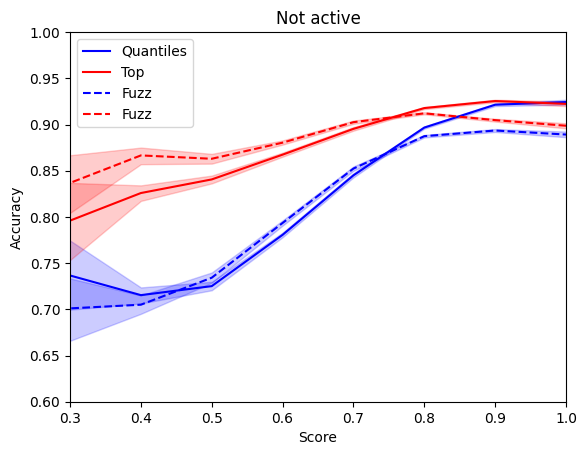

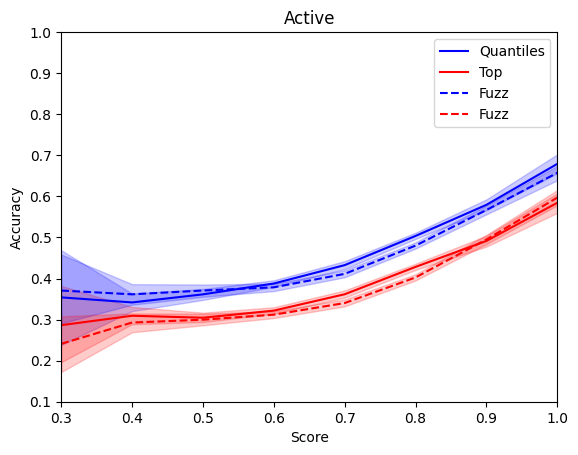

<Figure size 640x480 with 0 Axes>

In [72]:
#plt.figure(figsize=(10,10))
sns.lineplot(data=merged_data, x="score_recall_rounded",y = "inactive_accuracy_quantiles",label="Quantiles",color="blue")
sns.lineplot(data=merged_data, x="score_recall_rounded",y = "inactive_accuracy_top",label="Top",color="red")
sns.lineplot(data=merged_data, x="score_fuzz_rounded",y = "inactive_accuracy_quantiles",label="Fuzz",color="blue",linestyle="--")
sns.lineplot(data=merged_data, x="score_fuzz_rounded",y = "inactive_accuracy_top",label="Fuzz",color="red",linestyle="--")
plt.legend()
plt.title("Not active")
plt.ylabel("Accuracy")
plt.xlabel("Score")
plt.xlim(0.3,1)
plt.ylim(0.6,1)
plt.savefig("blog_figures/recall_accuracy_inactive.svg")
plt.figure()
sns.lineplot(data=merged_data, x="score_recall_rounded",y = "active_accuracy_quantiles",label="Quantiles",color="blue")
sns.lineplot(data=merged_data, x="score_recall_rounded",y = "active_accuracy_top",label="Top",color="red")
sns.lineplot(data=merged_data, x="score_fuzz_rounded",y = "active_accuracy_quantiles",label="Fuzz",color="blue",linestyle="--")
sns.lineplot(data=merged_data, x="score_fuzz_rounded",y = "active_accuracy_top",label="Fuzz",color="red",linestyle="--")
plt.legend()
plt.xlim(0.3,1)
plt.ylim(0.1,1)
plt.title("Active")
plt.ylabel("Accuracy")
plt.xlabel("Score")
plt.savefig("blog_figures/recall_accuracy_active.svg")
plt.figure()

# Position

In [107]:
# Get true_positives, true_negatives, total_inactive, total_active per feature
per_feature_results_top_grouped = per_feature_results_top.groupby("position").sum(numeric_only=True).reset_index()
per_feature_results_quantiles_grouped = per_feature_results_quantiles.groupby("position").sum(numeric_only=True).reset_index()
per_feature_results_top_grouped["active_accuracy"] = per_feature_results_top_grouped["true_positives"]/per_feature_results_top_grouped["total_active"]
per_feature_results_quantiles_grouped["active_accuracy"] = per_feature_results_quantiles_grouped["true_positives"]/per_feature_results_quantiles_grouped["total_active"]


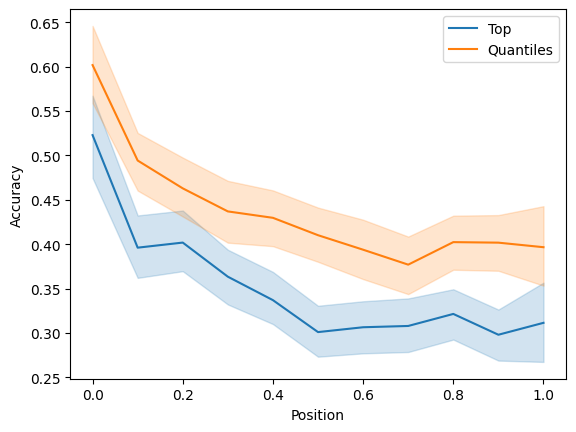

In [124]:
per_feature_results_top_grouped["rounded_position"] = per_feature_results_top_grouped["position"].round(1)
per_feature_results_quantiles_grouped["rounded_position"] = per_feature_results_quantiles_grouped["position"].round(1)
sns.lineplot(data=per_feature_results_top_grouped, x="rounded_position",y="active_accuracy",label="Top")
sns.lineplot(data=per_feature_results_quantiles_grouped, x="rounded_position",y="active_accuracy",label="Quantiles")
plt.legend()
plt.xlabel("Position")
plt.ylabel("Accuracy")
plt.savefig("blog_figures/position_accuracy.svg")

# Estimation active right, threshold

In [73]:
def accuracy_threshold(scores_folder,num_sentences):
    all_results = []
    for sentence_idx in tqdm(range(num_sentences)):
        files = glob.glob(f"{scores_folder}{sentence_idx}/*")
        feature_results = []
        for file in files:
            # read the csv
            df = pd.read_csv(file)
            feature_results.append(df)
        if len(feature_results) < 1:
            continue
        feature_results = pd.concat(feature_results)
        active_features = feature_results[feature_results["ground_truth"]==1].reset_index(drop=True)
        non_active_features = feature_results[feature_results["ground_truth"]==0].reset_index(drop=True)
        non_active_probabilities = non_active_features["probability"]
        # generate 130000 samples from the probability distribution in non_active_probabilities
        sampled_non_active_probabilities = np.random.choice(non_active_probabilities,size=130000,replace=True)
        # calculate the accuracy of the sampled non active features
        labels = np.zeros(len(active_features)+len(sampled_non_active_probabilities)+len(non_active_features))
        labels[:len(active_features)] = 1
        predictions = np.concatenate([active_features["probability"],sampled_non_active_probabilities,non_active_features["probability"]])
        # sort predictions and labels by predictions
        sorted_idx = np.argsort(predictions)
        predictions = predictions[sorted_idx]
        labels = labels[sorted_idx]
        percentages_of_data = [0.5,0.6,0.7,0.8,0.9,0.95,0.99,0.999]
        for threshold in percentages_of_data:
            # select only the points where the percentage of prediction is higher than the threshold
            selected_predictions = predictions[predictions>=threshold]
            selected_labels = labels[predictions>=threshold]
            if len(selected_predictions) < 1:
                continue
            # correct active accuracy
            active_accuracy = (selected_labels==1).sum()/len(active_features)
            # correct inactive accuracy
            inactive_accuracy = (len(predictions)-(selected_labels==0).sum())/len(predictions)
            all_results.append({"threshold":1-threshold,"active_accuracy":active_accuracy,"inactive_accuracy":inactive_accuracy,"num_predictions":len(selected_predictions)})
    return all_results
            



In [74]:
# for each sentence we are only accounting for 1000 non active features and 50 active features. There are actually 131000 non active features. Here we sample the missing ones to estimate correct accuracy over the distribution.
all_results_top = accuracy_threshold(scores_folder="/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/131k/8b/32/top/",num_sentences=2000)
all_results_quantiles = accuracy_threshold(scores_folder="/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/scores/131k/8b/32/quantiles/",num_sentences=2000)




100%|██████████| 2000/2000 [00:23<00:00, 86.60it/s]


In [70]:
all_results_quantiles

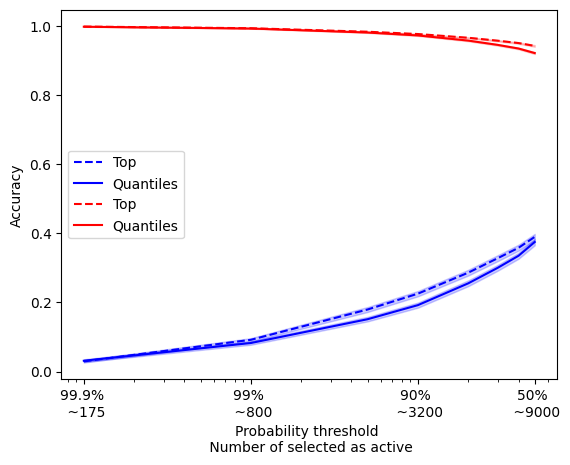

In [80]:
data_top = pd.DataFrame(all_results_top)
data_quantiles = pd.DataFrame(all_results_quantiles)
num_predictions_top=data_top.groupby("threshold").mean()["num_predictions"]
num_predictions_quantiles=data_quantiles.groupby("threshold").mean()["num_predictions"]
sns.lineplot(data=data_top,x="threshold",y="active_accuracy",label="Top",color="blue",linestyle="--")
sns.lineplot(data=data_quantiles,x="threshold",y="active_accuracy",label="Quantiles",color="blue")
sns.lineplot(data=data_top,x="threshold",y="inactive_accuracy",label="Top",linestyle="--",color="red")
sns.lineplot(data=data_quantiles,x="threshold",y="inactive_accuracy",label="Quantiles",color="red")
plt.ylabel("Accuracy")
plt.xlabel("Probability threshold \n Number of selected as active")
plt.xscale("log")
#plt.yscale("log")
plt.xticks([0.001,0.01,0.1,0.5],["99.9% \n ~175","99% \n ~800","90% \n ~3200","50% \n ~9000"])
plt.legend()
plt.savefig("blog_figures/threshold_accuracy.svg")


# Kl divergence

In [105]:
# read the list of kl divergences saved in "extras/full_simulation/kl_div/8b/32/quantiles/kl_divergences.json"
with open("kl_div/8b/32/quantiles/kl_divergences.json","r") as f:
    kl_divergences_8b_quantiles = json.load(f)
with open("kl_div/8b/32/top/kl_divergences.json","r") as f:
    kl_divergences_8b_top = json.load(f)
with open("kl_div/8b-top_top5/32/top/kl_divergences.json","r") as f:
    kl_divergences_8b_top_top5 = json.load(f)
with open("kl_div/8bfuzz/32/quantiles/kl_divergences.json","r") as f:
    kl_divergences_8b_fuzz = json.load(f)
with open("kl_div/8brecall/32/quantiles/kl_divergences.json","r") as f:
    kl_divergences_8b_recall = json.load(f)
with open("kl_div/70b/32/quantiles/kl_divergences.json","r") as f:
    kl_divergences_70b = json.load(f)



In [106]:
reconstruction_kl = kl_divergences_8b_quantiles["reconstruction"] # it's the same for all methods
prediction_quantiles = kl_divergences_8b_quantiles["prediction"]
prediction_top = kl_divergences_8b_top["prediction"]
prediction_top_top5 = kl_divergences_8b_top_top5["prediction"]
prediction_fuzz = kl_divergences_8b_fuzz["prediction"]
prediction_recall = kl_divergences_8b_recall["prediction"]
prediction_70b = kl_divergences_70b["prediction"]


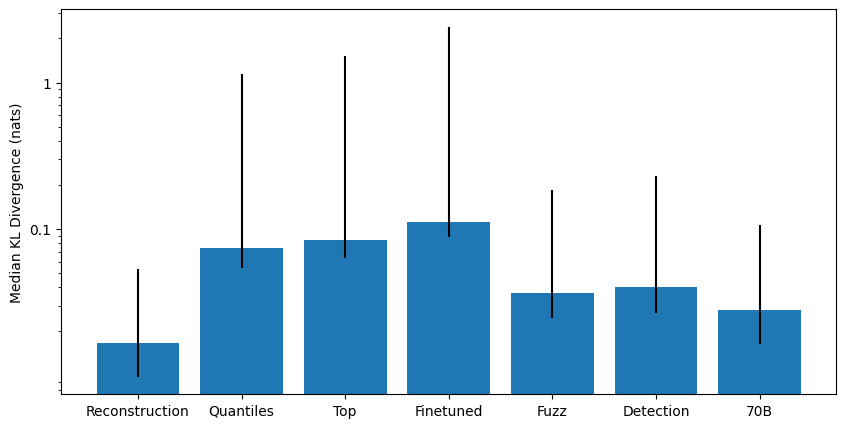

In [107]:
median_reconstruction_kl = np.median(reconstruction_kl)
interval_reconstruction_kl = np.percentile(reconstruction_kl,[25,75])
median_prediction_quantiles = np.median(prediction_quantiles)
interval_prediction_quantiles = np.percentile(prediction_quantiles,[25,75])
median_prediction_top = np.median(prediction_top)
interval_prediction_top = np.percentile(prediction_top,[25,75])
median_prediction_top_top5 = np.median(prediction_top_top5)
interval_prediction_top_top5 = np.percentile(prediction_top_top5,[25,75])
median_prediction_fuzz = np.median(prediction_fuzz)
interval_prediction_fuzz = np.percentile(prediction_fuzz,[25,75])
median_prediction_recall = np.median(prediction_recall)
interval_prediction_recall = np.percentile(prediction_recall,[25,75])
median_prediction_70b = np.median(prediction_70b)
interval_prediction_70b = np.percentile(prediction_70b,[25,75])
plt.figure(figsize=(10,5))
plt.bar(np.arange(7),[median_reconstruction_kl,median_prediction_quantiles,median_prediction_top,median_prediction_top_top5,median_prediction_fuzz,median_prediction_recall,median_prediction_70b])
# add error bars
error_bars = np.array([interval_reconstruction_kl,interval_prediction_quantiles,interval_prediction_top,interval_prediction_top_top5,interval_prediction_fuzz,interval_prediction_recall,interval_prediction_70b]).T


plt.errorbar(np.arange(7),[median_reconstruction_kl,median_prediction_quantiles,median_prediction_top,median_prediction_top_top5,median_prediction_fuzz,median_prediction_recall,median_prediction_70b],
             yerr=error_bars, fmt="none",ecolor="black")
plt.xticks(np.arange(7),["Reconstruction","Quantiles","Top","Finetuned","Fuzz","Detection","70B"])
plt.ylabel("Median KL Divergence (nats)")
plt.yscale("log")
plt.yticks([0.1,1],["0.1","1"])
plt.savefig("blog_figures/kl_divergences.png",dpi=300)

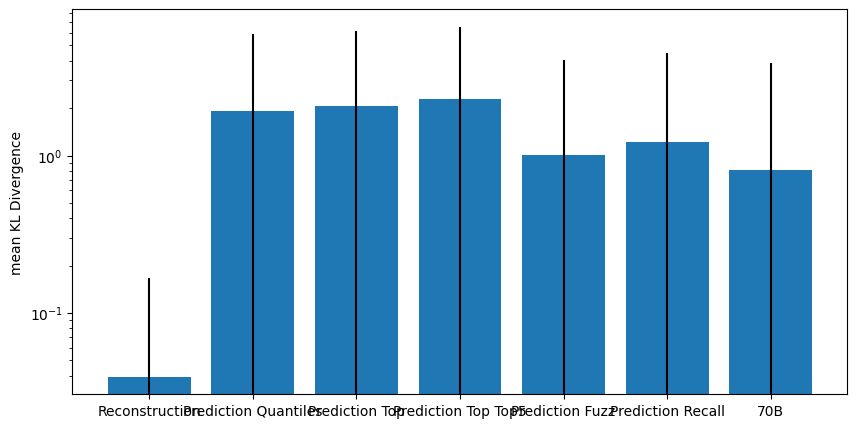

In [108]:
mean_reconstruction_kl = np.mean(reconstruction_kl)
interval_reconstruction_kl = np.std(reconstruction_kl)
mean_prediction_quantiles = np.mean(prediction_quantiles)
interval_prediction_quantiles = np.std(prediction_quantiles)
mean_prediction_top = np.mean(prediction_top)
interval_prediction_top = np.std(prediction_top)
mean_prediction_top_top5 = np.mean(prediction_top_top5)
interval_prediction_top_top5 = np.std(prediction_top_top5)
mean_prediction_fuzz = np.mean(prediction_fuzz)
interval_prediction_fuzz = np.std(prediction_fuzz)
mean_prediction_recall = np.mean(prediction_recall)
interval_prediction_recall = np.std(prediction_recall)
mean_prediction_70b = np.mean(prediction_70b)
interval_prediction_70b = np.std(prediction_70b)
plt.figure(figsize=(10,5))
plt.bar(np.arange(7),[mean_reconstruction_kl,mean_prediction_quantiles,mean_prediction_top,mean_prediction_top_top5,mean_prediction_fuzz,mean_prediction_recall,mean_prediction_70b])
# add error bars
error_bars = np.array([interval_reconstruction_kl,interval_prediction_quantiles,interval_prediction_top,interval_prediction_top_top5,interval_prediction_fuzz,interval_prediction_recall,interval_prediction_70b]).T


plt.errorbar(np.arange(7),[mean_reconstruction_kl,mean_prediction_quantiles,mean_prediction_top,mean_prediction_top_top5,mean_prediction_fuzz,mean_prediction_recall,mean_prediction_70b],
             yerr=error_bars, fmt="none",ecolor="black")
plt.xticks(np.arange(7),["Reconstruction","Prediction Quantiles","Prediction Top","Prediction Top Top5","Prediction Fuzz","Prediction Recall","70B"])
plt.ylabel("mean KL Divergence")
plt.yscale("log")
plt.show()


# Activations 

In [133]:
# read the list of kl divergences saved in "extras/full_simulation/kl_div/8b/32/quantiles/kl_divergences.json"
with open("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/activations/8b/32/quantiles/all_results_with_quantiles.csv","r") as f:
    activations_8b_quantiles = pd.read_csv(f)
with open("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/activations/8b/32/top/all_results_with_quantiles.csv","r") as f:
    activations_8b_top = pd.read_csv(f)
with open("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/activations/8bfuzz/32/quantiles/all_results_with_quantiles.csv","r") as f:
    activations_8b_fuzz = pd.read_csv(f)
with open("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/full_simulation/activations/8brecall/32/quantiles/all_results_with_quantiles.csv","r") as f:
    activations_8b_recall = pd.read_csv(f)



In [210]:
activations_8b_quantiles=activations_8b_quantiles[activations_8b_quantiles["predicted_quantile"]!=-1]
activations_8b_quantiles=activations_8b_quantiles[activations_8b_quantiles["closest_density"]<50]
activations_8b_quantiles["closest_density_normalized"] = activations_8b_quantiles["closest_density"]/49*9
activations_8b_quantiles["closest_linear_normalized"] = activations_8b_quantiles["closest_linear"]/49*9

activations_8b_top=activations_8b_top[activations_8b_top["predicted_quantile"]!=-1]
activations_8b_top=activations_8b_top[activations_8b_top["closest_density"]<50]
activations_8b_top["closest_density_normalized"] = activations_8b_top["closest_density"]/49*9
activations_8b_top["closest_linear_normalized"] = activations_8b_top["closest_linear"]/49*9

activations_8b_fuzz=activations_8b_fuzz[activations_8b_fuzz["predicted_quantile"]!=-1]
activations_8b_fuzz=activations_8b_fuzz[activations_8b_fuzz["closest_density"]<50]
activations_8b_fuzz["closest_density_normalized"] = activations_8b_fuzz["closest_density"]/49*9
activations_8b_fuzz["closest_linear_normalized"] = activations_8b_fuzz["closest_linear"]/49*9

activations_8b_recall=activations_8b_recall[activations_8b_recall["predicted_quantile"]!=-1]
activations_8b_recall=activations_8b_recall[activations_8b_recall["closest_density"]<50]
activations_8b_recall["closest_density_normalized"] = activations_8b_recall["closest_density"]/49*9
activations_8b_recall["closest_linear_normalized"] = activations_8b_recall["closest_linear"]/49*9


([<matplotlib.axis.XTick at 0x7f1d9e4e5540>,
 [Text(0, 0, '0'), Text(3, 0, '3'), Text(6, 0, '6'), Text(9, 0, '9')])

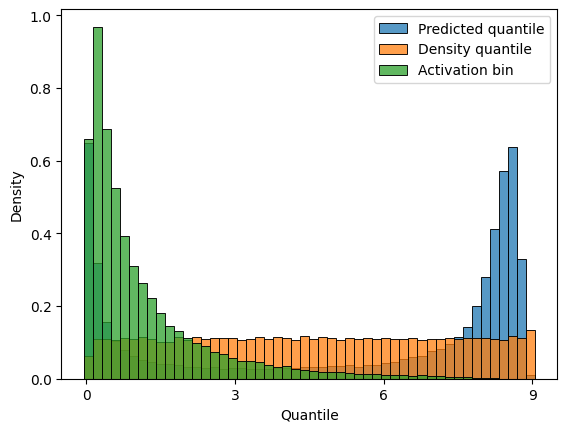

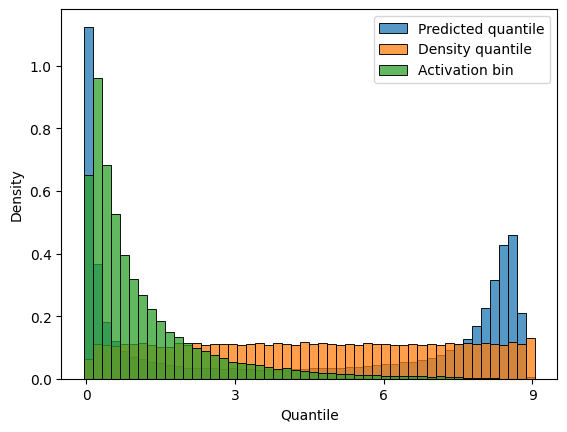

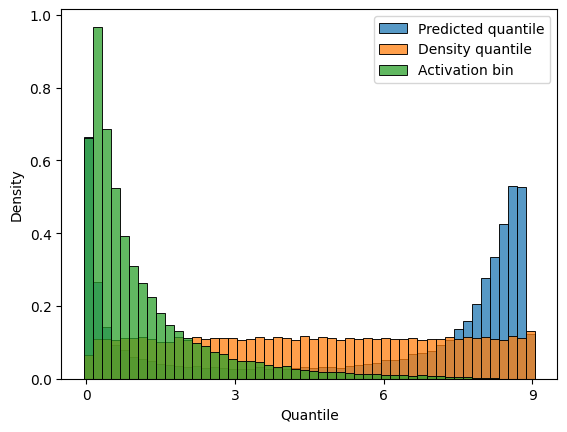

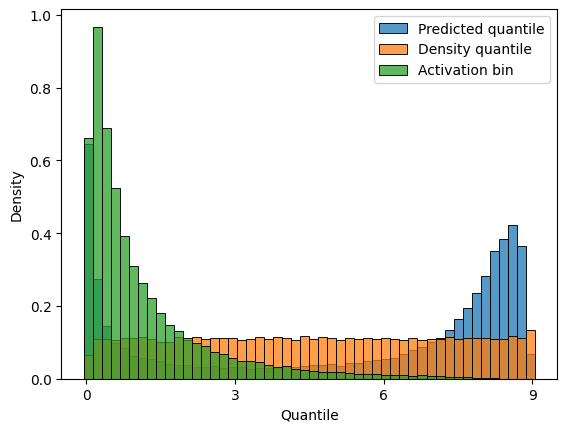

In [228]:
#sns.histplot(data=activations_8b_quantiles,x="predicted_quantile",bins=np.arange(11)-0.5)
# I want to have a bar at 0, 1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9
sns.histplot(data=activations_8b_quantiles,x="expected_quantile",bins=np.linspace(-0.05,9.05,51),label="Predicted quantile",stat="density")
sns.histplot(data=activations_8b_quantiles,x="closest_density_normalized",bins=np.linspace(-0.05,9.05,51),label="Density quantile",stat="density")
sns.histplot(data=activations_8b_quantiles,x="closest_linear_normalized",bins=np.linspace(-0.05,9.05,51),label="Activation bin",stat="density")
plt.xlabel("Quantile")
plt.legend()
plt.xticks([0,3,6,9],["0","3","6","9"])
plt.savefig("blog_figures/activations_quantiles.svg",dpi=300)
plt.figure()
sns.histplot(data=activations_8b_top,x="expected_quantile",bins=np.linspace(-0.05,9.05,51),label="Predicted quantile",stat="density")
sns.histplot(data=activations_8b_top,x="closest_density_normalized",bins=np.linspace(-0.05,9.05,51),label="Density quantile",stat="density")
sns.histplot(data=activations_8b_top,x="closest_linear_normalized",bins=np.linspace(-0.05,9.05,51),label="Activation bin",stat="density")
plt.xlabel("Quantile")
plt.legend()
plt.xticks([0,3,6,9],["0","3","6","9"])
plt.figure()
sns.histplot(data=activations_8b_fuzz,x="expected_quantile",bins=np.linspace(-0.05,9.05,51),label="Predicted quantile",stat="density")
sns.histplot(data=activations_8b_fuzz,x="closest_density_normalized",bins=np.linspace(-0.05,9.05,51),label="Density quantile",stat="density")
sns.histplot(data=activations_8b_fuzz,x="closest_linear_normalized",bins=np.linspace(-0.05,9.05,51),label="Activation bin",stat="density")
plt.xlabel("Quantile")
plt.legend()
plt.xticks([0,3,6,9],["0","3","6","9"])
plt.figure()
sns.histplot(data=activations_8b_recall,x="expected_quantile",bins=np.linspace(-0.05,9.05,51),label="Predicted quantile",stat="density")
sns.histplot(data=activations_8b_recall,x="closest_density_normalized",bins=np.linspace(-0.05,9.05,51),label="Density quantile",stat="density")
sns.histplot(data=activations_8b_recall,x="closest_linear_normalized",bins=np.linspace(-0.05,9.05,51),label="Activation bin",stat="density")
plt.xlabel("Quantile")
plt.legend()
plt.xticks([0,3,6,9],["0","3","6","9"])



In [220]:
# Pearson correlation between expected_quantile, closest_density_normalized, closest_linear_normalize and activation
activations_8b_quantiles[["expected_quantile", "closest_density_normalized", "closest_linear_normalized"]].corr(method="pearson")


,expected_quantile,closest_density_normalized,closest_linear_normalized
expected_quantile,1.000000,0.087436,0.163488
closest_density_normalized,0.087436,1.000000,0.677912
closest_linear_normalized,0.163488,0.677912,1.000000


In [221]:
activations_8b_top[["expected_quantile", "closest_density_normalized", "closest_linear_normalized"]].corr(method="pearson")



,expected_quantile,closest_density_normalized,closest_linear_normalized
expected_quantile,1.000000,0.111328,0.212730
closest_density_normalized,0.111328,1.000000,0.681058
closest_linear_normalized,0.212730,0.681058,1.000000


In [222]:
activations_8b_fuzz[["expected_quantile", "closest_density_normalized", "closest_linear_normalized"]].corr(method="pearson")


,expected_quantile,closest_density_normalized,closest_linear_normalized
expected_quantile,1.000000,0.081229,0.177433
closest_density_normalized,0.081229,1.000000,0.678433
closest_linear_normalized,0.177433,0.678433,1.000000


In [223]:
activations_8b_recall[["expected_quantile", "closest_density_normalized", "closest_linear_normalized"]].corr(method="pearson")


,expected_quantile,closest_density_normalized,closest_linear_normalized
expected_quantile,1.000000,0.084457,0.172982
closest_density_normalized,0.084457,1.000000,0.678558
closest_linear_normalized,0.172982,0.678558,1.000000


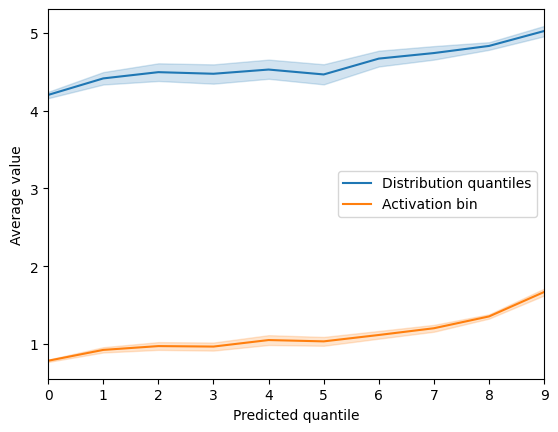

In [229]:
plt.figure()
activations_8b_top["expected_quantile_rounded"] = activations_8b_top["expected_quantile"].round(0)
sns.lineplot(data=activations_8b_top,x="expected_quantile_rounded",y="closest_density_normalized",label="Distribution quantiles")
sns.lineplot(data=activations_8b_top,x="expected_quantile_rounded",y="closest_linear_normalized",label="Activation bin")
plt.ylabel("Average value")
plt.xlabel("Predicted quantile")
plt.xlim(0,9)
plt.savefig("blog_figures/predicted_vs_value.svg",dpi=300)


